# Search for a bakery location (neighborhood) in Barcelona City (Spain)

## Table of contents
* [1 Introduction: Business Problem](#introduction)
* [2 Data: Loading and displaying BCN neighborhoods and bakeries](#data)
* [3 Methodology](#methodology)
* [4 Results and Discussion](#results)
* [6 Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

**Barcelona (BCN)**  is the capital from Catalonia (region and province from Spain). With a population of  1,7 million people is the second city in Spain and one of the most populated in the EU. As a  global leading tourist, business and cultural centre it offers to residents and visitants all kind of products and services and has an extensive transportation network by sea, air, train and motorways to Spain and the rest of Europe. Small businesses and start-ups are continuously establishing due to all this facts plus a nice climate and lively/friendly character from citizens.

In this project an investor is interested in placing a “gourmet” bakery in Barcelona city and since “Location”  is one of the most important success Bakery’s KPIs  (others are: product quality, price and range, processes, business plan and persons)  has asked us to help him to decide which neighborhood (one or "top five") could be the most convenient taking into account:

-	Barcelona city has 73 neighborhoods  (included in 10 districts)

-	**Competition**: more than 400 hundred bakeries spread all over the city. Number of bakeries in selected neighborhood/s should be low. Try to avoid neighborhoods having more than one recognized as “best bakeries” 

-	**Population and density** should be high rated
(high people flow could be a plus -tourists and citizens coming from other neighborhoods- but residents population should be high however

-	Product prices will be higher than average due to quality. Try to avoid neighborhoods having comparatively low **Family income**.

-	**Store Rental prices (€/m2 month)** should not be excessive in any case.


Also, you will use the Foursquare API to explore neighborhoods in New York City. You will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. You will use the *k*-means clustering algorithm to complete this task. Finally, you will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters.

## 2. Loading Data and displaying BCN neighborhoods and reference bakeries  <a name="data"></a>

First we import all libraries needed

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
from pandas.compat import StringIO

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

#!conda install -c conda-forge wordcloud==1.4.1 --yes
from wordcloud import WordCloud, STOPWORDS
import time
import warnings
warnings.simplefilter('ignore')

Barcelona has 73 neighborhoods and from the the city hall web (www.bcn.cat/estadistica) you can get **Population, Area, Density, Familyincom** and residential **Rental€m2** variables. Decimal coordinates for **Latitude and Longitude** of Neighborhood centers are available at Wikipedia plus Geohack. I have combined and checked this information in an Excel file.

Let's load the data.

In [2]:
coordfile="BCNData.xlsx"
neighborhoods=pd.read_excel(coordfile)
neighborhoods.head()

IdNeig                           Neighborhood  IdBor       Borough  \
0       1                                  Raval      1  CIUTAT VELLA   
1       2                            Barri Gotic      1  CIUTAT VELLA   
2       3                            Barceloneta      1  CIUTAT VELLA   
3       4  Sant Pere, Santa Caterina i la Ribera      1  CIUTAT VELLA   
4       5                             Fort Pienc      2      EIXAMPLE   

   Population   Area  Density  Familyincom  Rental€m2   Latitude  Longitude  
0       47608  109.8    433.4         71.2       14.0  41.380000   2.168610  
1       16062   84.2    190.8        106.1       13.8  41.382778   2.176944  
2       14996  131.4    114.1         79.6       16.9  41.379440   2.189170  
3       22721  111.4    203.9         99.4       15.0  41.384700   2.182600  
4       32016   92.9    344.7        106.5       13.1  41.395675   2.183703

And make sure that the dataset has 10 districts (boroughs) and 73 neighborhoods

In [3]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 10 boroughs and 73 neighborhoods.


Let's load an Excel file I have prepared containing data from 10 bakeries referenced as "Best Bakeries" in a newspaper article (Jan 2019) [1]. Coordinates have been obtained through Nominatim geocode and Google Maps. "Postcode" column dropped due to neighborhood analysis in all the project.

In [4]:
bestbkrs="BestbakeriesBCN.xlsx"
bestbakeries=pd.read_excel(bestbkrs)
bestbakeries.drop(['Postcode'], axis='columns', inplace=True)
bestbakeries

Name                        Address   Latitude  Longitude  \
0             PA SERRA           Olivera 31 Barcelona  41.373472   2.157254   
1  HORNO SANTA MADRONA              Blai 59 Barcelona  41.374277   2.163049   
2         FORN BALUARD           Baluard 38 Barcelona  41.380047   2.189250   
3         FORN MISTRAL  Ronda San Antoni 96 Barcelona  41.384636   2.164160   
4               TURRIS           Aribau 158 Barcelona  41.387652   2.160209   
5         FLECA BALMES           Balmes 156 Barcelona  41.394643   2.156071   
6      FORN SANT JOSEP   Roger de Lluria 98 Barcelona  41.395702   2.165426   
7          FORN EUROPA       Pare Lainez 13 Barcelona  41.407067   2.165495   
8     GALETTE & PASTIM              Tajo 21 Barcelona  41.429677   2.160938   
9     FORN DEL PASSEIG     Fabra i Puig 140 Barcelona  41.430400   2.180959   

                      Neighborhood  
0                        Poble Sec  
1                        Poble Sec  
2                      Barceloneta  
3                            Raval  
4         Antiga Esquerra Eixample  
5                   Dreta Eixample  
6                   Dreta Eixample  
7  Camp d'en Grassot i Gracia Nova  
8                            Horta  
9                            Porta

#### Use geopy library to get the latitude and longitude values of Barcelona

In [5]:
address = 'Barcelona, Spain'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Barcelona, Spain are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Barcelona, Spain are 41.3828939, 2.1774322.


#### Using folium library, we create a map of Barcelona with neighborhoods (blue) and Best Bakeries (green) superimposed on top.

In [6]:
# create map of Bcn using latitude and longitude values
map_bcn = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bcn)  

for lat, lng, name, address in zip(bestbakeries['Latitude'], bestbakeries['Longitude'], bestbakeries['Name'], bestbakeries['Address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.5,
        parse_html=False).add_to(map_bcn)  
   
map_bcn

<a id='item2'></a>

#### Define Foursquare Credentials and Version

In [7]:
CLIENT_ID = 'OP1TJ1CKHYINOF4TBY0W4LZP41QI3UJ5S1LLGP22CZDO02NY' # your Foursquare ID
CLIENT_SECRET = 'CW0FII04GMB04EFCBTESPLHBF0OZMLDP2BLHZGVWASPQYWPL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OP1TJ1CKHYINOF4TBY0W4LZP41QI3UJ5S1LLGP22CZDO02NY
CLIENT_SECRET:CW0FII04GMB04EFCBTESPLHBF0OZMLDP2BLHZGVWASPQYWPL


#### Let's create a function to get bakeries for every neighborhood 

In [8]:
def getNearbyBakeries(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4bf58dd8d48988d16a941735'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['formattedAddress'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_bakeries = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_bakeries.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Address',
                  'Distance',           
                  'Venue Category']
    
    return(nearby_bakeries)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *bcn_bakeries*.

In [9]:
LIMIT=250
bcn_bakeries = getNearbyBakeries(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Raval
Barri Gotic
Barceloneta
Sant Pere, Santa Caterina i la Ribera
Fort Pienc
Sagrada Familia
Dreta Eixample
Antiga Esquerra Eixample
Nova Esquerra Eixample
Sant Antoni
Poble Sec
la Marina del Prat Vermell
la Marina de Port
la Font de la Guatlla
Hostafrancs
la Bordeta
Sants - Badal
Sants
les Corts
la Maternitat i Sant Ramon
Pedralbes
Vallvidrera, Tibidabo, Les Planes
Sarria
Tres Torres
Sant Gervasi - la Bonanova
Sant Gervasi - Galvany
Putxet i el Farro
Vallcarca Penitents
el Coll
la Salut
Vila de Gracia
Camp d'en Grassot i Gracia Nova
Baix Guinardo
Can Baro
Guinardo
Font d'en Fargues
el Carmel
la Teixonera
Sant Genis dels Agudells
Montbau
la Vall d'Hebron
la Clota
Horta
Vilapicina i Torre Llobeta
Porta
Turo de la Peira
Can Peguera
la Guineueta
Canyelles
les Roquetes
Verdun
la Prosperitat
la Trinitat Nova
Torre Baro
Ciutat Meridiana
Vallbona
la Trinitat Vella
Baro de Viver
Bon Pastor
Sant Andreu
la Sagrera
Congres i els Indians
Navas
Camp de l'Arpa
Clot
Parc i Llacuna del Poblenou
Vila

## 3. Methodology  <a name="methodology"></a>

After loading data from files (neighborhoods, best bakeries) and from Foursquare(FS) (bakeries) we use geocode and folium library to display a map of Barcelona with best bakeries and neighborhood centers dotted with different colors.  We observe than centers are not geographically “centered”  but we will use them because usually represent the center of  venues, commerce, cultural  and people movement what is most relevant for our project.

We will follow somehow a “funnel” process to propose just one (or five) neighborhoods from 73 candidates. Three big stages, **Bakeries analysis,  Neighborhood and Clustering analysis** and **Neighborhood similarity** will end us to our **Result** (final top ranking).
 
First stage, **Bakeries analysis** is subdivided in "Displaying and Analysing Bakeries", "Neighborhood variable analysis", "Getting FS Venues" and "First Discarding neighborhoods".


### Methodology index
* [3.1 Displaying and Analysing Bakeries](#31)
* [3.2 Neighborhood variable analysis](#32)
* [3.3 Getting FS Neighborhood Venues](#33)
* [3.4 First Discarding neighborhoods](#34)
* [3.5 Neighborhood and Clustering analysis](#35)
* [3.6 Neighborhood similarity and Final top ranking](#36)

### 3.1 Displaying and Analysing Bakeries  <a name="31"></a>

Let's clean,prepare "panaderias" (bakeries) dataframe and show total number and a sample list of bakeries

In [10]:
# Drop categories different from bakery

panaderias=bcn_bakeries[bcn_bakeries['Venue Category']=="Bakery"]

# Ensure best bakeries are included in panaderias dataframe

copy_bestbakeries=bestbakeries.rename(columns={'Name':'Venue','Latitude':'Venue Latitude','Longitude':'Venue Longitude'})
panaderias=panaderias.append(copy_bestbakeries,sort=True)
panaderias['Distance'].fillna(0,inplace=True)
panaderias['Venue Category'].fillna('Bakery',inplace=True)

# Erase duplicate bakeries based on identical coordinates

panaderias=panaderias.drop_duplicates(['Venue Latitude', 'Venue Longitude'], keep='first')

print('Total number of bakeries is ',panaderias.shape[0])
panaderias[['Venue','Venue Latitude','Venue Longitude','Neighborhood','Distance']].sort_values(by=['Neighborhood','Venue'],ascending=True).head(5)

Total number of bakeries is  501


Venue  Venue Latitude  Venue Longitude  \
160              365       41.393903         2.155967   
154            Boldú       41.394123         2.156113   
158            Boldú       41.393616         2.152624   
175  Bread  & Coffee       41.387674         2.158770   
151      Cloudstreet       41.388539         2.150878   

                 Neighborhood  Distance  
160  Antiga Esquerra Eixample     434.0  
154  Antiga Esquerra Eixample     460.0  
158  Antiga Esquerra Eixample     445.0  
175  Antiga Esquerra Eixample     408.0  
151  Antiga Esquerra Eixample     388.0

Let's group bakeries by neighborhood to get mean, min and max bakeries and detect number of neighborhoods with bakeries.

In [11]:
pandsporbarrio=panaderias.groupby('Neighborhood').count()
pandsporbarrio=pandsporbarrio[['Venue']]
pandsporbarrio['Neighborhood']=pandsporbarrio.index
print(pandsporbarrio.describe())

           Venue
count  68.000000
mean    7.367647
std     7.110859
min     1.000000
25%     3.000000
50%     4.000000
75%     9.250000
max    32.000000


We have 5 neighborhoods(73-68)without any bakery (radius=500m), and some with just one(min value)

We create a  dataframe with a column having the amount of bakeries by neighborhood,and show a sample from ten most bakery crowded neighborhoods (column Nobkrys)

In [12]:
bkpneighb=pandsporbarrio.sort_values(by='Venue',ascending=True)
bkpneighb=bkpneighb.merge(neighborhoods,left_on='Neighborhood',right_on='Neighborhood',how='outer')
bkpneighb=bkpneighb.rename(columns={'Venue':'Nobkrys'})

# Replacing NaN by 0 bakeries if needed
bkpneighb['Nobkrys'].fillna(0,inplace=True)
bkpneighb=bkpneighb.sort_values(by='Nobkrys',ascending=False)

bkpneighb.head(10)

Nobkrys              Neighborhood  IdNeig  IdBor          Borough  \
67     32.0  Antiga Esquerra Eixample       8      2         EIXAMPLE   
66     27.0            Dreta Eixample       7      2         EIXAMPLE   
65     24.0                 les Corts      19      4        LES CORTS   
64     24.0                     Raval       1      1     CIUTAT VELLA   
63     23.0               Barri Gotic       2      1     CIUTAT VELLA   
62     21.0           Sagrada Familia       6      2         EIXAMPLE   
61     18.0            Vila de Gracia      31      6           GRACIA   
60     17.0    Sant Gervasi - Galvany      26      5  SARRIA-SGERVASI   
59     17.0               Sant Antoni      10      2         EIXAMPLE   
58     16.0            Camp de l'Arpa      64     10       SANT MARTI   

    Population   Area  Density  Familyincom  Rental€m2   Latitude  Longitude  
67       42284  123.4    342.5        137.2       14.1  41.390061   2.155061  
66       44052  212.3    207.5        175.9       14.0  41.395278   2.166667  
65       46009  141.3    325.7        120.0       14.8  41.384167   2.132778  
64       47608  109.8    433.4         71.2       14.0  41.380000   2.168610  
63       16062   84.2    190.8        106.1       13.8  41.382778   2.176944  
62       51539  105.1    490.4        101.8       13.7  41.403561   2.174347  
61       50662  132.6    382.1        104.4       14.6  41.404047   2.155894  
60       47666  165.9    287.3        192.1       14.8  41.396667   2.143889  
59       38345   80.1    478.7        104.2       13.2  41.378010   2.159490  
58       38168   74.2    514.6         81.7       13.0  41.411433   2.182500

#### Let's see the distribution of num bakeries vs num neighborhoods

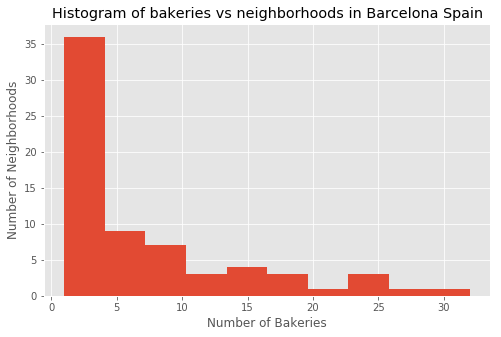

In [13]:
pandsporbarrio['Venue'].plot(kind='hist', figsize=(8, 5))
plt.title('Histogram of bakeries vs neighborhoods in Barcelona Spain') 
plt.ylabel('Number of Neighborhoods') 
plt.xlabel('Number of Bakeries') 
plt.show()

According to histogram, it could be reasonable to consider unless first 5 neighborhoods -with most bakeries- candidates to be discarded for our target location

In [14]:
number_to_discard=5
high_nobkrys=bkpneighb[['Neighborhood']].head(number_to_discard)
high_nobkrys

Neighborhood
67  Antiga Esquerra Eixample
66            Dreta Eixample
65                 les Corts
64                     Raval
63               Barri Gotic

Let's draw a map containing bakeries (brown), 10 best bakeries (green) and neighborhood centers (blue).

In [15]:
map_bcn = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bcn)  

for lat, lng, name, address in zip(bestbakeries['Latitude'], bestbakeries['Longitude'], bestbakeries['Name'], bestbakeries['Address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=1,
        parse_html=False).add_to(map_bcn)  

for lat, lng, venue, neighborhood in zip(panaderias['Venue Latitude'], panaderias['Venue Longitude'], panaderias['Venue'], panaderias['Neighborhood']):
    label = '{}, {}'.format(venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='brown',
        fill=True,
        fill_color='brown',
        fill_opacity=0.5,
        parse_html=False).add_to(map_bcn)  
     
map_bcn


Let's try now a Marker cluster for FS bakeries and red points for best bakeries, blue points for neighborhood centers

In [16]:
map_bcn = folium.Map(location = [latitude, longitude], zoom_start = 13)

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bcn)  

for lat, lng, name, address in zip(bestbakeries['Latitude'], bestbakeries['Longitude'], bestbakeries['Name'], bestbakeries['Address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.9,
        parse_html=False).add_to(map_bcn)  

# instantiate a mark cluster object for the incidents in the dataframe
grbakeries = plugins.MarkerCluster().add_to(map_bcn)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, venue, neighborhood in zip(panaderias['Venue Latitude'], panaderias['Venue Longitude'],panaderias['Venue'],panaderias['Neighborhood']) :
    label = '{}, {}'.format(venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(grbakeries)

# display map
map_bcn

We can see diferent bakeries clustering levels depending on zoom although not strictly adjusted to neighborhoods. Clearly downtown, the most touristic zone, has highest bakery density.

Let's try using a choropleth map based on 'Bakeries per Neighborhood' instead of cluster marker

In [17]:
bcn_geo = r'bcn_neighborhoods.json' # geojson file

In [18]:
map_bcn = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_bcn.choropleth(
    geo_data=bcn_geo,
    data=bkpneighb,
    columns=['Neighborhood','Nobkrys'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.4,
    legend_name='FS Bakeries per Neighborhood',
    reset=True
)

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bcn)  
    
for lat, lng, name, address in zip(bestbakeries['Latitude'], bestbakeries['Longitude'], bestbakeries['Name'], bestbakeries['Address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.9,
        parse_html=False).add_to(map_bcn)  
# display map
map_bcn

Once again downtown we see clearly downtown is the highest bakery density area, but differences among neighborhoods are better viewed. Further analysis inside a neighborhood or stree can be made using zoom option.

### 3.2  Neighborhood variable analysis <a name="32"></a>

#### 3.2.1 Correlation Overview

First let's see now if there are some relevant variable correlation

In [19]:
neighborhoods[['Population','Area','Density','Familyincom','Rental€m2']].corr()

Population      Area   Density  Familyincom  Rental€m2
Population     1.000000 -0.089139  0.562983     0.225536   0.427674
Area          -0.089139  1.000000 -0.400790     0.112659   0.110638
Density        0.562983 -0.400790  1.000000    -0.138543   0.119444
Familyincom    0.225536  0.112659 -0.138543     1.000000   0.722849
Rental€m2      0.427674  0.110638  0.119444     0.722849   1.000000

Most significative is 0,72 correlation between 'Family income' and store 'Rental price €/m2-month' but we will consider not enough to discard anyone. We are interested in having simultaneously high Family income and low rental€m2. 

#### 3.2.2  Considering Neighborhoods Density and Population

We are interested in neighborhoods having high population and high density population (Density column)

In [20]:
neighborhoods[['Density','Population']].describe()

Density    Population
count   73.000000     73.000000
mean   249.842466  22202.863014
std    153.665110  14622.058303
min      0.800000    610.000000
25%    115.300000  10401.000000
50%    242.900000  20487.000000
75%    348.200000  30584.000000
max    584.300000  58180.000000

We could assume neighborhoods having a density less than quantile 15% persons/ha have very low potential to be selected. 

In [21]:
liminf_dens=neighborhoods['Density'].quantile(0.15)
low_density=neighborhoods[neighborhoods['Density']<liminf_dens]
print('Number of discarded neighborhoods by low density : ',low_density.shape[0])
low_density=low_density[['Neighborhood','Density']].sort_values(by='Density',ascending=True)
low_density

Number of discarded neighborhoods by low density :  11


Neighborhood  Density
11         la Marina del Prat Vermell      0.8
21  Vallvidrera, Tibidabo, Les Planes      4.1
53                         Torre Baro     16.2
55                           Vallbona     23.0
39                            Montbau     24.9
41                           la Clota     34.2
38           Sant Genis dels Agudells     39.9
20                          Pedralbes     44.7
58                         Bon Pastor     66.7
40                   la Vall d'Hebron     78.6
22                             Sarria     82.3

We could assume neighborhoods having a population less than quantile 40% persons have low potential to be selected. Being more restrictive in population than density is intended because of giving not so many relevance to movements inside a neighborhood.

In [22]:
liminf_pop=neighborhoods['Population'].quantile(0.4)
low_pop=neighborhoods[neighborhoods['Population']<liminf_pop]
print('Number of discarded neighborhoods by low population : ',low_pop.shape[0])
low_pop=low_pop[['Neighborhood','Population']].sort_values(by='Population',ascending=True)
low_pop

Number of discarded neighborhoods by low population :  29


Neighborhood  Population
41                                    la Clota         610
11                  la Marina del Prat Vermell        1149
55                                    Vallbona        1372
46                                 Can Peguera        2271
57                               Baro de Viver        2539
53                                  Torre Baro        2856
21           Vallvidrera, Tibidabo, Les Planes        4670
39                                     Montbau        5102
40                            la Vall d'Hebron        5784
38                    Sant Genis dels Agudells        6854
48                                   Canyelles        6856
52                            la Trinitat Nova        7261
28                                     el Coll        7412
33                                    Can Baro        8994
66                               Vila Olimpica        9367
35                           Font d'en Fargues        9383
56                           la Trinitat Vella        9983
54                            Ciutat Meridiana       10342
13                       la Font de la Guatlla       10401
37                                la Teixonera       11619
20                                   Pedralbes       12076
50                                      Verdun       12353
58                                  Bon Pastor       12560
29                                    la Salut       13185
68  Diagonal Mar i  Front Maritim del Poblenou       13629
61                       Congres i els Indians       14116
2                                  Barceloneta       14996
65                 Parc i Llacuna del Poblenou       15134
47                                la Guineueta       15231

Let's try now our choropleth bcn map using population, brown points as bakeries, green: best bakeries, and blue point as neighborhood centers.

In [23]:
map_bcn = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_bcn.choropleth(
    geo_data=bcn_geo,
    data=bkpneighb,
    columns=['Neighborhood','Population'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.4,
    legend_name='Population  (pa/Ha)',
    reset=True
)
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bcn)  
    
for lat, lng, venue, neighborhood in zip(panaderias['Venue Latitude'], panaderias['Venue Longitude'], panaderias['Venue'], panaderias['Neighborhood']):
    label = '{}, {}'.format(venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='black',
        fill=True,
        fill_color='brown',
        fill_opacity=0.5,
        parse_html=False).add_to(map_bcn)  
    
for lat, lng, name, address in zip(bestbakeries['Latitude'], bestbakeries['Longitude'], bestbakeries['Name'], bestbakeries['Address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.9,
        parse_html=False).add_to(map_bcn)  
# display map
map_bcn

#### 3.2.3 Family Income

Selling "artesan","gourmet" bread and products will be more difficult in neighborhoods having low Family income, base index for BCN city is 100

In [24]:
neighborhoods[['Familyincom']].describe()

Familyincom
count    73.000000
mean     93.671233
std      42.709775
min      38.600000
25%      65.100000
50%      82.900000
75%     105.700000
max     248.800000

Which neighborhoods are having less than quantile(0.3)  Family income  (Average base index for BCN is 100)

In [25]:
liminf_income=neighborhoods['Familyincom'].quantile(0.3)

low_income=neighborhoods[neighborhoods['Familyincom']<liminf_income]
print('Number of discarded neighborhoods by low family income : ',low_income.shape[0])
low_income[['Neighborhood','Familyincom']].sort_values(by='Familyincom',ascending=True)


Number of discarded neighborhoods by low family income :  22


Neighborhood  Familyincom
54            Ciutat Meridiana         38.6
11  la Marina del Prat Vermell         40.0
55                    Vallbona         40.9
53                  Torre Baro         46.5
56           la Trinitat Vella         47.1
52            la Trinitat Nova         48.2
49                les Roquetes         49.7
50                      Verdun         51.3
46                 Can Peguera         51.5
45            Turo de la Peira         51.9
48                   Canyelles         52.2
47                la Guineueta         53.8
36                   el Carmel         54.2
51              la Prosperitat         56.0
72         la Verneda i la Pau         57.0
69             Besos i Maresme         60.4
43  Vilapicina i Torre Llobeta         63.8
44                       Porta         64.4
58                  Bon Pastor         65.1
71    Sant Marti de Provençals         67.4
57               Baro de Viver         68.9
12           la Marina de Port         69.3

Let's try now our choropleth bcn map using Family income, brown points as bakeries, green: best bakeries, and blue point as neighborhood centers.

In [26]:
map_bcn = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_bcn.choropleth(
    geo_data=bcn_geo,
    data=bkpneighb,
    columns=['Neighborhood','Familyincom'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.4,
    legend_name='Familyincom  (base index=100)',
    reset=True
)
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bcn)  
    
for lat, lng, venue, neighborhood in zip(panaderias['Venue Latitude'], panaderias['Venue Longitude'], panaderias['Venue'], panaderias['Neighborhood']):
    label = '{}, {}'.format(venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='black',
        fill=True,
        fill_color='brown',
        fill_opacity=0.5,
        parse_html=False).add_to(map_bcn)  
    
for lat, lng, name, address in zip(bestbakeries['Latitude'], bestbakeries['Longitude'], bestbakeries['Name'], bestbakeries['Address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.9,
        parse_html=False).add_to(map_bcn)  
# display map
map_bcn

Bakerys concentration is lower on lighter colored (lower) Family income neighborhoods. Excepcionally, two very high Family income neighborhoods (Pedralbes and Tres Torres) almost have not bakeries.

#### 3.3.4  Rental€m2

Rental paid for the store will be one relevent expense in our business

In [27]:
neighborhoods[['Rental€m2']].describe()

Rental€m2
count  73.000000
mean   12.527808
std     2.107739
min     7.500000
25%    11.400000
50%    12.300000
75%    13.900000
max    17.200000

With Store Rental€m2-month we observe again min,mean, max, percentiles. Investor does not want to have high rental expenses with this first shop. Consequently we create a new discard set **toohigh_rental** including neighborhoods with values higher than quantile 75% but also limiting to 10 neighborhoods 

(current "store" rental rates can be even higher than neighborhood "residential" rental rates we have in source file)

In [28]:
limits_rental=neighborhoods['Rental€m2'].quantile(0.75)

toohigh_rental=neighborhoods[neighborhoods['Rental€m2']>limits_rental]
print('Number of discarded neighborhoods by too high rental : 10 from',toohigh_rental.shape[0])
toohigh_rental=toohigh_rental[['Neighborhood','Rental€m2']].sort_values(by='Rental€m2',ascending=False).head(10)
toohigh_rental

Number of discarded neighborhoods by too high rental : 10 from 17


Neighborhood  Rental€m2
22                                      Sarria       17.2
66                               Vila Olimpica       16.9
2                                  Barceloneta       16.9
23                                 Tres Torres       16.4
24                  Sant Gervasi - la Bonanova       16.1
20                                   Pedralbes       15.4
68  Diagonal Mar i  Front Maritim del Poblenou       15.3
3        Sant Pere, Santa Caterina i la Ribera       15.0
18                                   les Corts       14.8
25                      Sant Gervasi - Galvany       14.8

<a id='item3'></a>

### 3.3  Getting FS Neighborhood Venues <a name="33"></a>

Let's create a function to get venues for every neighborhood in the parameter dataframe

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['formattedAddress'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Address',
                  'Distance',           
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called *bcn_venues*.

In [30]:
LIMIT=250
bcn_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )



Raval
Barri Gotic
Barceloneta
Sant Pere, Santa Caterina i la Ribera
Fort Pienc
Sagrada Familia
Dreta Eixample
Antiga Esquerra Eixample
Nova Esquerra Eixample
Sant Antoni
Poble Sec
la Marina del Prat Vermell
la Marina de Port
la Font de la Guatlla
Hostafrancs
la Bordeta
Sants - Badal
Sants
les Corts
la Maternitat i Sant Ramon
Pedralbes
Vallvidrera, Tibidabo, Les Planes
Sarria
Tres Torres
Sant Gervasi - la Bonanova
Sant Gervasi - Galvany
Putxet i el Farro
Vallcarca Penitents
el Coll
la Salut
Vila de Gracia
Camp d'en Grassot i Gracia Nova
Baix Guinardo
Can Baro
Guinardo
Font d'en Fargues
el Carmel
la Teixonera
Sant Genis dels Agudells
Montbau
la Vall d'Hebron
la Clota
Horta
Vilapicina i Torre Llobeta
Porta
Turo de la Peira
Can Peguera
la Guineueta
Canyelles
les Roquetes
Verdun
la Prosperitat
la Trinitat Nova
Torre Baro
Ciutat Meridiana
Vallbona
la Trinitat Vella
Baro de Viver
Bon Pastor
Sant Andreu
la Sagrera
Congres i els Indians
Navas
Camp de l'Arpa
Clot
Parc i Llacuna del Poblenou
Vila

In [31]:
print('Number of venues returned by FS is ',bcn_venues.shape[0])
bcn_venues.head()

Number of venues returned by FS is  4677


Neighborhood  Neighborhood Latitude  Neighborhood Longitude        Venue  \
0        Raval                  41.38                 2.16861    A Tu Bola   
1        Raval                  41.38                 2.16861  Grey Street   
2        Raval                  41.38                 2.16861  La Robadora   
3        Raval                  41.38                 2.16861         Llop   
4        Raval                  41.38                 2.16861        33/45   

   Venue Latitude  Venue Longitude  \
0       41.380096         2.169054   
1       41.380848         2.166609   
2       41.379500         2.170463   
3       41.381849         2.169511   
4       41.381059         2.167399   

                                             Address  Distance  \
0  [C. de l'Hospital, 78, 08001 Barcelona Cataluñ...        38   
1  [C. del Peu de la Creu, 25 (C. de la Lluna), 0...       191   
2    [Robadors 18, 08001 Barcelona Cataluña, España]       164   
3  [42 Carrer del Carme, 08001 Barcelona Cataluña...       219   
4  [C. Joaquín Costa, 4, 08001 Barcelona Cataluña...       155   

     Venue Category  
0  Tapas Restaurant  
1         Gift Shop  
2         Gastropub  
3        Restaurant  
4      Cocktail Bar

In [32]:
bcnvc=bcn_venues.groupby('Venue Category').count().sort_values(by='Venue',ascending=False)
print('Number of different venue categories is ',bcnvc.shape[0])  
print('Venue Categories having more venue returned :')
bcnvc['Venue'].head(5)


Number of different venue categories is  292
Venue Categories having more venue returned :


Venue Category
Tapas Restaurant      257
Spanish Restaurant    248
Restaurant            214
Hotel                 182
Café                  176
Name: Venue, dtype: int64

Let's see how is distribution from venues vs neighborhoods

In [33]:
bcnvg=bcn_venues.groupby('Neighborhood').count()
bcnvg=bcnvg[['Venue']]

bcnvg['Venue'].plot(kind='hist', figsize=(8, 5))
plt.title('Histogram of venues from neighborhoods in Barcelona Spain') 
plt.ylabel('Number of Neighborhoods') 
plt.xlabel('Number of Venues') 
plt.show()

We could assume neighborhoods having less than 20 venues returned have low tourist/non-residential people flow and can be candidates to discard

In [34]:
low_movement=bcnvg[bcnvg['Venue']<20].sort_values(by='Venue',ascending=True)
low_movement['Neighborhood']=low_movement.index
print('Number of discarded neighborhoods by low_movement : ',low_movement.shape[0])
low_movement[['Venue']]

Number of discarded neighborhoods by low_movement :  11


Venue
Neighborhood                            
Sant Genis dels Agudells               5
la Trinitat Vella                      5
Vallvidrera, Tibidabo, Les Planes      6
Vallbona                               7
Ciutat Meridiana                       8
Torre Baro                             8
la Trinitat Nova                      13
Pedralbes                             15
la Marina del Prat Vermell            16
Canyelles                             18
les Roquetes                          18

### 3.4  First Discarding neighborhoods  <a name="34"></a>

First we create a discard set with neighborhoods with 2 or more "best bakeries"  

In [35]:
b=bestbakeries.groupby('Neighborhood').count()>1
b['Neighborhood']=b.index
b=b[b['Name']==True]

bbdiscard=b[['Neighborhood']]
bbdiscard

Neighborhood
Neighborhood                  
Dreta Eixample  Dreta Eixample
Poble Sec            Poble Sec

We create a list including all discardable sets created previously 

In [36]:
discard_df=[high_nobkrys,low_density,low_pop,low_income,toohigh_rental,low_movement,bbdiscard,]

We merge (outer join) all sets and show a sample

In [37]:
from functools import reduce
common_discard = reduce(lambda  left,right: pd.merge(left,right,on=['Neighborhood'],
                                            how='outer'), discard_df)

common_discard['Selected']='NO'
common_discard=common_discard[['Neighborhood','Selected']]
common_discard.head()

Neighborhood Selected
0  Antiga Esquerra Eixample       NO
1            Dreta Eixample       NO
2                 les Corts       NO
3                     Raval       NO
4               Barri Gotic       NO

A new column 'Selected' is updated according discard made, and initial number of candidates and a list of them is shown.

In [38]:
neighborhoods= neighborhoods.merge(common_discard,left_on='Neighborhood',right_on='Neighborhood',how='left')
neighborhoods['Selected'].fillna('CAN',inplace=True)
candidates=neighborhoods[neighborhoods['Selected']=='CAN']
print('Initial number of candidates end Stage 1 is : ',candidates.shape[0])
candidates

Initial number of candidates end Stage 1 is :  23


IdNeig                     Neighborhood  IdBor          Borough  \
4        5                       Fort Pienc      2         EIXAMPLE   
5        6                  Sagrada Familia      2         EIXAMPLE   
8        9           Nova Esquerra Eixample      2         EIXAMPLE   
9       10                      Sant Antoni      2         EIXAMPLE   
14      15                      Hostafrancs      3   SANTS-MONTJUIC   
15      16                       la Bordeta      3   SANTS-MONTJUIC   
16      17                    Sants - Badal      3   SANTS-MONTJUIC   
17      18                            Sants      3   SANTS-MONTJUIC   
19      20       la Maternitat i Sant Ramon      4        LES CORTS   
26      27                Putxet i el Farro      5  SARRIA-SGERVASI   
27      28              Vallcarca Penitents      6           GRACIA   
30      31                   Vila de Gracia      6           GRACIA   
31      32  Camp d'en Grassot i Gracia Nova      6           GRACIA   
32      33                    Baix Guinardo      7   HORTA-GUINARDO   
34      35                         Guinardo      7   HORTA-GUINARDO   
42      43                            Horta      7   HORTA-GUINARDO   
59      60                      Sant Andreu      9      SANT ANDREU   
60      61                       la Sagrera      9      SANT ANDREU   
62      63                            Navas      9      SANT ANDREU   
63      64                   Camp de l'Arpa     10       SANT MARTI   
64      65                             Clot     10       SANT MARTI   
67      68                        Poble Nou     10       SANT MARTI   
70      71          Provençals del Poblenou     10       SANT MARTI   

    Population   Area  Density  Familyincom  Rental€m2   Latitude  Longitude  \
4        32016   92.9    344.7        106.5       13.1  41.395675   2.183703   
5        51539  105.1    490.4        101.8       13.7  41.403561   2.174347   
8        58180  133.8    434.9        110.2       13.9  41.383389   2.149000   
9        38345   80.1    478.7        104.2       13.2  41.378010   2.159490   
14       15904   41.0    387.7         99.0       13.5  41.375556   2.143056   
15       18530   57.7    321.4         79.0       12.2  41.370494   2.137097   
16       23987   41.1    584.3         81.0       13.0  41.375278   2.126667   
17       41127  109.8    374.6         99.0       13.1  41.375730   2.135250   
19       23948  190.3    125.9        114.2       13.6  41.384342   2.122206   
26       29470   84.6    348.2        144.6       14.6  41.405556   2.145278   
27       15759  120.9    130.4        112.5       13.6  41.412778   2.143056   
30       50662  132.6    382.1        104.4       14.6  41.404047   2.155894   
31       34329   65.0    528.5        105.7       13.8  41.406110   2.167220   
32       25672   56.0    458.6         92.0       12.7  41.409228   2.166922   
34       36467  130.8    278.7         79.1       12.1  41.418378   2.175561   
42       26715  308.2     86.7         79.8       11.8  41.429503   2.160100   
59       57183  184.1    310.6         77.7       11.9  41.436111   2.191667   
60       29084   97.2    299.1         77.1       11.9  41.422358   2.186319   
62       22129   42.3    522.7         81.6       12.0  41.415744   2.186900   
63       38168   74.2    514.6         81.7       13.0  41.411433   2.182500   
64       27039   69.6    388.5         83.6       12.6  41.409370   2.190174   
67       33843  154.5    219.1         99.9       14.5  41.399167   2.203889   
70       20487  110.5    185.4        102.3       13.6  41.409400   2.200560   

   Selected  
4       CAN  
5       CAN  
8       CAN  
9       CAN  
14      CAN  
15      CAN  
16      CAN  
17      CAN  
19      CAN  
26      CAN  
27      CAN  
30      CAN  
31      CAN  
32      CAN  
34      CAN  
42      CAN  
59      CAN  
60      CAN  
62      CAN  
63      CAN  
64      CAN  
67      CAN  
70      CAN

### 3.5. Neighborhood and Clustering analysis <a name="35"></a>

We construct a dataframe with dummy variables from column "Venue category" in FS returnes venues

In [39]:
# one hot encoding
bcn_onehot = pd.get_dummies(bcn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bcn_onehot['Neighborhood'] = bcn_venues['Neighborhood'] 

columna = bcn_onehot.pop('Neighborhood') 
bcn_onehot.insert(0,'Neighborhood',columna)

print(bcn_onehot.shape)
bcn_onehot.head()

(4677, 292)


Neighborhood  Accessories Store  African Restaurant  American Restaurant  \
0        Raval                  0                   0                    0   
1        Raval                  0                   0                    0   
2        Raval                  0                   0                    0   
3        Raval                  0                   0                    0   
4        Raval                  0                   0                    0   

   Amphitheater  Antique Shop  Arcade  Arepa Restaurant  \
0             0             0       0                 0   
1             0             0       0                 0   
2             0             0       0                 0   
3             0             0       0                 0   
4             0             0       0                 0   

   Argentinian Restaurant  Art Gallery     ...       Veterinarian  \
0                       0            0     ...                  0   
1                       0            0     ...                  0   
2                       0            0     ...                  0   
3                       0            0     ...                  0   
4                       0            0     ...                  0   

   Video Game Store  Video Store  Vietnamese Restaurant  Wine Bar  Wine Shop  \
0                 0            0                      0         0          0   
1                 0            0                      0         0          0   
2                 0            0                      0         0          0   
3                 0            0                      0         0          0   
4                 0            0                      0         0          0   

   Winery  Wings Joint  Women's Store  Yoga Studio  
0       0            0              0            0  
1       0            0              0            0  
2       0            0              0            0  
3       0            0              0            0  
4       0            0              0            0  

[5 rows x 292 columns]

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [40]:
bcn_grouped = bcn_onehot.groupby('Neighborhood').mean().reset_index()
print(bcn_grouped.shape)
bcn_grouped

(73, 292)


Neighborhood  Accessories Store  \
0                     Antiga Esquerra Eixample           0.000000   
1                                Baix Guinardo           0.000000   
2                                  Barceloneta           0.000000   
3                                Baro de Viver           0.000000   
4                                  Barri Gotic           0.000000   
5                              Besos i Maresme           0.000000   
6                                   Bon Pastor           0.014085   
7              Camp d'en Grassot i Gracia Nova           0.000000   
8                               Camp de l'Arpa           0.000000   
9                                     Can Baro           0.000000   
10                                 Can Peguera           0.000000   
11                                   Canyelles           0.000000   
12                            Ciutat Meridiana           0.000000   
13                                        Clot           0.000000   
14                       Congres i els Indians           0.000000   
15  Diagonal Mar i  Front Maritim del Poblenou           0.000000   
16                              Dreta Eixample           0.000000   
17                           Font d'en Fargues           0.000000   
18                                  Fort Pienc           0.010000   
19                                    Guinardo           0.000000   
20                                       Horta           0.000000   
21                                 Hostafrancs           0.000000   
22                                     Montbau           0.000000   
23                                       Navas           0.000000   
24                      Nova Esquerra Eixample           0.000000   
25                 Parc i Llacuna del Poblenou           0.000000   
26                                   Pedralbes           0.000000   
27                                   Poble Nou           0.000000   
28                                   Poble Sec           0.000000   
29                                       Porta           0.000000   
..                                         ...                ...   
43                                      Sarria           0.000000   
44                                  Torre Baro           0.000000   
45                                 Tres Torres           0.000000   
46                            Turo de la Peira           0.000000   
47                                    Vallbona           0.000000   
48                         Vallcarca Penitents           0.000000   
49           Vallvidrera, Tibidabo, Les Planes           0.000000   
50                                      Verdun           0.000000   
51                               Vila Olimpica           0.000000   
52                              Vila de Gracia           0.000000   
53                  Vilapicina i Torre Llobeta           0.000000   
54                                   el Carmel           0.000000   
55                                     el Coll           0.000000   
56                                  la Bordeta           0.000000   
57                                    la Clota           0.000000   
58                       la Font de la Guatlla           0.000000   
59                                la Guineueta           0.000000   
60                           la Marina de Port           0.000000   
61                  la Marina del Prat Vermell           0.000000   
62                  la Maternitat i Sant Ramon           0.000000   
63                              la Prosperitat           0.000000   
64                                  la Sagrera           0.000000   
65                                    la Salut           0.000000   
66                                la Teixonera           0.000000   
67                            la Trinitat Nova           0.000000   
68                           la Trinitat Vella           0.000000   
69                            la

Now, let's print each neighborhood along with the top 5 most common venues

In [41]:
num_top_venues = 5

for hood in bcn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bcn_grouped[bcn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Antiga Esquerra Eixample----
                      venue  freq
0                     Hotel  0.10
1        Spanish Restaurant  0.08
2              Cocktail Bar  0.06
3       Japanese Restaurant  0.05
4  Mediterranean Restaurant  0.05


----Baix Guinardo----
                venue  freq
0                 Bar  0.07
1    Tapas Restaurant  0.06
2          Restaurant  0.04
3  Spanish Restaurant  0.04
4  Italian Restaurant  0.04


----Barceloneta----
                      venue  freq
0          Tapas Restaurant  0.11
1         Paella Restaurant  0.09
2        Seafood Restaurant  0.07
3                       Bar  0.06
4  Mediterranean Restaurant  0.06


----Baro de Viver----
                venue  freq
0  Spanish Restaurant  0.12
1       Metro Station  0.08
2               Plaza  0.08
3         Supermarket  0.08
4                 Gym  0.04


----Barri Gotic----
                venue  freq
0    Tapas Restaurant  0.09
1               Plaza  0.07
2  Spanish Restaurant  0.07
3            Wine B

First, let's write a function to sort the venues in descending order.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create a new dataframe displaying top 10 venues category for each neighborhood.

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bcn_grouped['Neighborhood']

for ind in np.arange(bcn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bcn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood     1st Most Common Venue  \
0                     Antiga Esquerra Eixample                     Hotel   
1                                Baix Guinardo                       Bar   
2                                  Barceloneta          Tapas Restaurant   
3                                Baro de Viver        Spanish Restaurant   
4                                  Barri Gotic          Tapas Restaurant   
5                              Besos i Maresme          Tapas Restaurant   
6                                   Bon Pastor            Clothing Store   
7              Camp d'en Grassot i Gracia Nova          Tapas Restaurant   
8                               Camp de l'Arpa                Restaurant   
9                                     Can Baro                     Plaza   
10                                 Can Peguera          Tapas Restaurant   
11                                   Canyelles              Soccer Field   
12                            Ciutat Meridiana             Metro Station   
13                                        Clot                Restaurant   
14                       Congres i els Indians          Tapas Restaurant   
15  Diagonal Mar i  Front Maritim del Poblenou                     Hotel   
16                              Dreta Eixample                     Hotel   
17                           Font d'en Fargues        Spanish Restaurant   
18                                  Fort Pienc                     Hotel   
19                                    Guinardo                Restaurant   
20                                       Horta        Spanish Restaurant   
21                                 Hostafrancs                     Hotel   
22                                     Montbau                Restaurant   
23                                       Navas                    Bakery   
24                      Nova Esquerra Eixample  Mediterranean Restaurant   
25                 Parc i Llacuna del Poblenou                Restaurant   
26                                   Pedralbes                      Park   
27                                   Poble Nou  Mediterranean Restaurant   
28                                   Poble Sec          Tapas Restaurant   
29                                       Porta             Grocery Store   
..                                         ...                       ...   
43                                      Sarria                    Bakery   
44                                  Torre Baro                     Plaza   
45                                 Tres Torres                Restaurant   
46                            Turo de la Peira          Tapas Restaurant   
47                                    Vallbona             Metro Station   
48                         Vallcarca Penitents                      Park   
49           Vallvidrera, Tibidabo, Les Planes                      Lake   
50                                      Verdun             Grocery Store   
51                               Vila Olimpica        Spanish Restaurant   
52                              Vila de Gracia          Tapas Restaurant   
53                  Vilapicina i Torre Llobeta          Tapas Restaurant   
54                                   el Carmel                     Plaza   
55                                     el Coll                     Plaza   
56                                  la Bordeta          Tapas Restaurant   
57                                    la Clota                     Plaza   
58                       la Font de la Guatlla        Spanish Restaurant   
59                                la Guineueta             Grocery Store   
60                           la Marina de Port        Spanish Restaurant   
61                  la Marina del Prat Vermell        Spanish Restaurant   
62                  la Maternitat i Sant Ramon        Spanish Restaurant   
63                              la Prosperitat        Spanish Restaurant   
64    

Run *k*-means to cluster the neighborhood into 5 clusters.

In [44]:
# set number of clusters
kclusters = 5
bcn_grouped_clustering = bcn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(bcn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 top venues for each neighborhood.

In [45]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bcn_merged = neighborhoods

# merge bcn_grouped with bcn_data to add non-venue columns for each neighborhood
bcn_merged = bcn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
bcn_merged.head() # check the last columns!

IdNeig                           Neighborhood  IdBor       Borough  \
0       1                                  Raval      1  CIUTAT VELLA   
1       2                            Barri Gotic      1  CIUTAT VELLA   
2       3                            Barceloneta      1  CIUTAT VELLA   
3       4  Sant Pere, Santa Caterina i la Ribera      1  CIUTAT VELLA   
4       5                             Fort Pienc      2      EIXAMPLE   

   Population   Area  Density  Familyincom  Rental€m2   Latitude  \
0       47608  109.8    433.4         71.2       14.0  41.380000   
1       16062   84.2    190.8        106.1       13.8  41.382778   
2       14996  131.4    114.1         79.6       16.9  41.379440   
3       22721  111.4    203.9         99.4       15.0  41.384700   
4       32016   92.9    344.7        106.5       13.1  41.395675   

               ...                1st Most Common Venue 2nd Most Common Venue  \
0              ...                     Tapas Restaurant    Spanish Restaurant   
1              ...                     Tapas Restaurant                 Plaza   
2              ...                     Tapas Restaurant     Paella Restaurant   
3              ...                     Tapas Restaurant              Wine Bar   
4              ...                                Hotel            Restaurant   

   3rd Most Common Venue     4th Most Common Venue 5th Most Common Venue  \
0                    Bar  Mediterranean Restaurant          Cocktail Bar   
1     Spanish Restaurant                       Bar              Wine Bar   
2     Seafood Restaurant  Mediterranean Restaurant                   Bar   
3                    Bar              Cocktail Bar                 Hotel   
4     Spanish Restaurant               Coffee Shop                Hostel   

  6th Most Common Venue          7th Most Common Venue 8th Most Common Venue  \
0            Restaurant                    Pizza Place                 Hotel   
1          Cocktail Bar                 Ice Cream Shop           Coffee Shop   
2          Burger Joint             Spanish Restaurant        Ice Cream Shop   
3          Dessert Shop  Vegetarian / Vegan Restaurant    Italian Restaurant   
4                Bistro       Mediterranean Restaurant                  Café   

  9th Most Common Venue         10th Most Common Venue  
0                   Pub                       Beer Bar  
1                 Hotel  Vegetarian / Vegan Restaurant  
2            Restaurant                       Wine Bar  
3                  Café             Spanish Restaurant  
4    Chinese Restaurant                         Bakery  

[5 rows x 23 columns]

Finally, let's visualize the resulting clusters

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bcn_merged['Latitude'], bcn_merged['Longitude'], bcn_merged['Neighborhood'], bcn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

Let's examine each cluster, first with a word cloud (avoiding "Restaurant") and looking at table with 10 most frequent venues.

#### Cluster 1 (red)

In [47]:
stopwords = set(STOPWORDS)
stopwords.add('Restaurant') # add the words Restaurant to stopwords

clu1=bcn_merged.loc[bcn_merged['Cluster Labels'] == 0, bcn_merged.columns[[1] + list(range(4, bcn_merged.shape[1]))]]
clu1w = clu1[clu1.columns[9:19]].to_string()
clu1w = clu1w[231:].replace("\n"," ")

# instantiate a word cloud object
Cluster1wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)
# generate the word cloud
Cluster1wc.generate(clu1w)
# display the word cloud
fig = plt.figure()
fig.set_figwidth(11) # set width
fig.set_figheight(4) # set height

plt.imshow(Cluster1wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Cluster 1 (red points), is comprised by 25 neighborhoods.  All of them except two are in the north of the city well grouped. Word cloud has a reasonable density (that means venue density) and number of words.  Spanish and tapas restaurant, Supermarket, Plaza, Grocery Store, Bakery and Café are most remarkable words. Neighborhoods seem to be just well populated residential and non-touristic areas, as we can confirm -by our native knowledge- checking the list of neighborhoods included.

Let's print this cluster total number of neighborhoods and table.

In [48]:
print(clu1.shape[0])
clu1

25


Neighborhood  Population   Area  Density  Familyincom  \
12           la Marina de Port       30584  125.5    243.8         69.3   
13       la Font de la Guatlla       10401   30.2    344.3         82.9   
33                    Can Baro        8994   38.4    234.4         83.3   
34                    Guinardo       36467  130.8    278.7         79.1   
35           Font d'en Fargues        9383   65.7    142.8         92.5   
41                    la Clota         610   17.8     34.2         93.5   
42                       Horta       26715  308.2     86.7         79.8   
43  Vilapicina i Torre Llobeta       25591   56.7    451.2         63.8   
44                       Porta       25000   84.1    297.2         64.4   
45            Turo de la Peira       15467   35.4    436.8         51.9   
46                 Can Peguera        2271   12.0    190.0         51.5   
47                la Guineueta       15231   61.1    249.1         53.8   
49                les Roquetes       15590   64.2    242.9         49.7   
50                      Verdun       12353   23.7    520.3         51.3   
51              la Prosperitat       26389   59.5    443.7         56.0   
52            la Trinitat Nova        7261   56.0    129.6         48.2   
56           la Trinitat Vella        9983   81.0    123.3         47.1   
57               Baro de Viver        2539   23.0    110.4         68.9   
59                 Sant Andreu       57183  184.1    310.6         77.7   
60                  la Sagrera       29084   97.2    299.1         77.1   
61       Congres i els Indians       14116   40.7    346.8         75.1   
62                       Navas       22129   42.3    522.7         81.6   
69             Besos i Maresme       23009  127.4    180.5         60.4   
71    Sant Marti de Provençals       26146   74.5    350.8         67.4   
72         la Verneda i la Pau       28691  112.3    255.5         57.0   

    Rental€m2   Latitude  Longitude Selected  Cluster Labels  \
12       10.6  41.359583   2.140972       NO               0   
13       12.4  41.369681   2.144811       NO               0   
33       12.2  41.416384   2.162356       NO               0   
34       12.1  41.418378   2.175561      CAN               0   
35       12.1  41.424917   2.165528       NO               0   
41        8.0  41.429444   2.153611       NO               0   
42       11.8  41.429503   2.160100      CAN               0   
43       11.6  41.428761   2.170872       NO               0   
44       11.4  41.434650   2.174947       NO               0   
45       11.3  41.433008   2.165808       NO               0   
46        8.1  41.434900   2.166188       NO               0   
47       10.1  41.441342   2.171986       NO               0   
49       11.2  41.446875   2.175614       NO               0   
50       11.6  41.442600   2.175400       NO               0   
51       11.8  41.442661   2.181686       NO               0   
52       12.0  41.448581   2.185247       NO               0   
56       10.0  41.449100   2.193320       NO               0   
57        7.5  41.447906   2.200742       NO               0   
59       11.9  41.436111   2.191667      CAN               0   
60       11.9  41.422358   2.186319      CAN               0   
61       11.9  41.425881   2.180678       NO               0   
62       12.0  41.415744   2.186900      CAN               0   
69       10.9  41.417178   2.213572       NO               0   
71       11.5  41.417222   2.198056       NO               0   
72       11.2  41.421950   2.205311       NO               0   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
12    Spanish Restaurant                  Café         Grocery Store   
13    Spanish Restaurant                 Plaza            Restaurant   
33                 Plaza         Grocery Store    Spanish Restaurant   
34            Restaurant         Grocery Store    Spanish Restaurant   
35    Spanish Restaurant      Tapas Restau

#### Cluster 2 (purple)

In [49]:
clu2=bcn_merged.loc[bcn_merged['Cluster Labels'] == 1, bcn_merged.columns[[1] + list(range(4, bcn_merged.shape[1]))]]
clu2w = clu2[clu2.columns[9:19]].to_string()
clu2w = clu2w[231:].replace("\n"," ")

# instantiate a word cloud object
Cluster2wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)
# generate the word cloud
Cluster2wc.generate(clu2w)

fig = plt.figure()
fig.set_figwidth(11) # set width
fig.set_figheight(4) # set height

# display the word cloud
plt.imshow(Cluster2wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Cluster 2  (purple points), is comprised by 35 neighborhoods.  All of them except one (Bon Pastor) are well grouped and spread over downtown, coastal and west areas of the city. Word cloud has a higher density (more and more different venues) and Spanish restaurant and Hotel are the top words, followed by Tapas, Café, Italian restaurant, Bakery and diferent kinds of specialized restaurants (Italian, Japanese, Burger, Pizza, Vegetarian…)

This cluster represents more people diversity, both residential and touristic and includes most centric neighborhoods in the city. “Bon Pastor” neighborhood is surely included because of having one of the biggest shopping centers in the city (La Maquinista)

Let's print this cluster total number of neighborhoods and table.

In [50]:
print(clu2.shape[0])
clu2

35


Neighborhood  Population   Area  Density  \
0                                        Raval       47608  109.8    433.4   
1                                  Barri Gotic       16062   84.2    190.8   
2                                  Barceloneta       14996  131.4    114.1   
3        Sant Pere, Santa Caterina i la Ribera       22721  111.4    203.9   
4                                   Fort Pienc       32016   92.9    344.7   
5                              Sagrada Familia       51539  105.1    490.4   
6                               Dreta Eixample       44052  212.3    207.5   
7                     Antiga Esquerra Eixample       42284  123.4    342.5   
8                       Nova Esquerra Eixample       58180  133.8    434.9   
9                                  Sant Antoni       38345   80.1    478.7   
10                                   Poble Sec       40228  460.5     87.4   
14                                 Hostafrancs       15904   41.0    387.7   
15                                  la Bordeta       18530   57.7    321.4   
16                               Sants - Badal       23987   41.1    584.3   
17                                       Sants       41127  109.8    374.6   
18                                   les Corts       46009  141.3    325.7   
19                  la Maternitat i Sant Ramon       23948  190.3    125.9   
22                                      Sarria       25032  304.2     82.3   
23                                 Tres Torres       16667   78.8    211.4   
24                  Sant Gervasi - la Bonanova       25774  223.5    115.3   
25                      Sant Gervasi - Galvany       47666  165.9    287.3   
26                           Putxet i el Farro       29470   84.6    348.2   
27                         Vallcarca Penitents       15759  120.9    130.4   
29                                    la Salut       13185   64.3    204.9   
30                              Vila de Gracia       50662  132.6    382.1   
31             Camp d'en Grassot i Gracia Nova       34329   65.0    528.5   
32                               Baix Guinardo       25672   56.0    458.6   
58                                  Bon Pastor       12560  188.2     66.7   
63                              Camp de l'Arpa       38168   74.2    514.6   
64                                        Clot       27039   69.6    388.5   
65                 Parc i Llacuna del Poblenou       15134  111.4    135.8   
66                               Vila Olimpica        9367   94.3     99.3   
67                                   Poble Nou       33843  154.5    219.1   
68  Diagonal Mar i  Front Maritim del Poblenou       13629  123.7    110.2   
70                     Provençals del Poblenou       20487  110.5    185.4   

    Familyincom  Rental€m2   Latitude  Longitude Selected  Cluster Labels  \
0          71.2       14.0  41.380000   2.168610       NO               1   
1         106.1       13.8  41.382778   2.176944       NO               1   
2          79.6       16.9  41.379440   2.189170       NO               1   
3          99.4       15.0  41.384700   2.182600       NO               1   
4         106.5       13.1  41.395675   2.183703      CAN               1   
5         101.8       13.7  41.403561   2.174347      CAN               1   
6         175.9       14.0  41.395278   2.166667       NO               1   
7         137.2       14.1  41.390061   2.155061       NO               1   
8         110.2       13.9  41.383389   2.149000      CAN               1   
9         104.2       13.2  41.378010   2.159490      CAN               1   
10         82.2       13.9  41.372780   2.162500       NO               1   
14         99.0       13.5  41.375556   2.143056      CAN               1   
15         79.0       12.2  41.370494   2.137097      CAN               1   
16         81.0       13.0  41.375278   2.126667      CAN               1   
17         99.0       13.1  41.375730   2.135250      CAN             

#### Cluster 3 (blue)

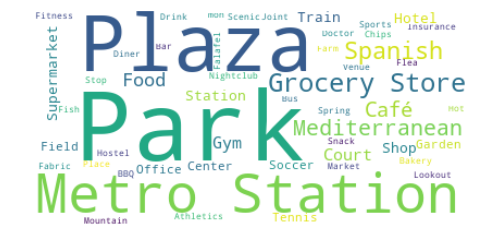

In [51]:
clu3=bcn_merged.loc[bcn_merged['Cluster Labels'] == 2, bcn_merged.columns[[1] + list(range(4, bcn_merged.shape[1]))]]
clu3w = clu3[clu3.columns[9:19]].to_string()
clu3w = clu3w[231:].replace("\n"," ")

# instantiate a word cloud object
Cluster3wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)
# generate the word cloud
Cluster3wc.generate(clu3w)

fig = plt.figure()
fig.set_figwidth(11) # set width
fig.set_figheight(4) # set height

# display the word cloud
plt.imshow(Cluster3wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Cluster 3  (blue points), is comprised by 11 neighborhoods close to mountain line going from southwest to north and far from the sea and downtown.  Word cloud density and diferent number of venues is lower than in clusters 1 and 2 and most significative are words Park, Plaza, and Metro Station.

This cluster represent residential neighborhoods, not so crowded as clusters 1 and 2, well communicated and provided of urban facilities  (Park, Plaza, Scenic joint, Garden, Gym, Lookout, Tennis, Mountain, Metro, Train, Bus).“Pedralbes”  outlier neighborhood is included here because clustering is based only in neighborhood venues and not in demographic variables such as population, family income or rental prices considered in Stage 1.

Let's print this cluster total number of neighborhoods and table.

In [52]:
print(clu3.shape[0])
clu3

11


Neighborhood  Population    Area  Density  Familyincom  \
11  la Marina del Prat Vermell        1149  1428.4      0.8         40.0   
20                   Pedralbes       12076   270.2     44.7        248.8   
28                     el Coll        7412    35.8    207.1         87.0   
36                   el Carmel       31551    94.2    335.1         54.2   
37                la Teixonera       11619    33.7    344.7         73.7   
39                     Montbau        5102   204.7     24.9         79.8   
40            la Vall d'Hebron        5784    73.6     78.6         95.8   
48                   Canyelles        6856    79.3     86.5         52.2   
53                  Torre Baro        2856   176.8     16.2         46.5   
54            Ciutat Meridiana       10342    35.5    291.0         38.6   
55                    Vallbona        1372    59.8     23.0         40.9   

    Rental€m2   Latitude  Longitude Selected  Cluster Labels  \
11      12.53  41.352103   2.139436       NO               2   
20      15.40  41.394722   2.113056       NO               2   
28      12.20  41.418056   2.145833       NO               2   
36      11.30  41.422383   2.155973       NO               2   
37      12.10  41.423131   2.145853       NO               2   
39      11.00  41.430925   2.142967       NO               2   
40      12.30  41.431624   2.148853       NO               2   
48       9.50  41.443127   2.166173       NO               2   
53       8.20  41.458356   2.180782       NO               2   
54       8.70  41.460914   2.174433       NO               2   
55       9.50  41.462331   2.182908       NO               2   

   1st Most Common Venue     2nd Most Common Venue     3rd Most Common Venue  \
11    Spanish Restaurant                     Plaza             Metro Station   
20                  Park  Mediterranean Restaurant                     Hotel   
28                 Plaza                      Park  Mediterranean Restaurant   
36                 Plaza             Grocery Store        Spanish Restaurant   
37         Grocery Store        Spanish Restaurant             Metro Station   
39            Restaurant                       Gym                      Café   
40                 Plaza                      Park        Spanish Restaurant   
48          Soccer Field                      Café             Grocery Store   
53                 Plaza             Metro Station             Grocery Store   
54         Metro Station               Supermarket                      Park   
55         Metro Station                 BBQ Joint             Train Station   

       4th Most Common Venue 5th Most Common Venue     6th Most Common Venue  \
11                Restaurant           Flea Market  Mediterranean Restaurant   
20      Gym / Fitness Center             Nightclub                  Bus Stop   
28        Spanish Restaurant        Scenic Lookout                     Hotel   
36             Metro Station                Bakery                  Mountain   
37                      Café                   Gym                Food Court   
39                      Park                 Plaza  Mediterranean Restaurant   
40                Restaurant                 Hotel             Grocery Store   
48                Hot Spring                  Park                      Food   
53             Train Station    Spanish Restaurant                      Park   
54  Mediterranean Restaurant                  Café             Train Station   
55                      Park         Grocery Store                     Plaza   

   7th Most Common Venue     8th Most Common Venue     9th Most Common Venue  \
11                  Park              Tennis Court          Insurance Office   
20    Spanish Restaurant                    Garden             Garden Center   
28    Athletics & Sports                      Café                       Bar   
36           Supermarket  Mediterranean Restaurant                      Café   
37          So

#### Cluster 4 (green)

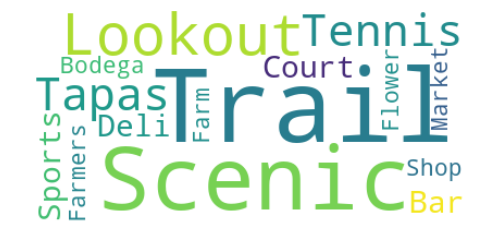

In [53]:
clu4=bcn_merged.loc[bcn_merged['Cluster Labels'] == 3, bcn_merged.columns[[1] + list(range(4, bcn_merged.shape[1]))]]
clu4w = clu4[clu4.columns[9:19]].to_string()
clu4w = clu4w[231:].replace("\n"," ")

# instantiate a word cloud object
Cluster4wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)
# generate the word cloud
Cluster4wc.generate(clu4w)

fig = plt.figure()
fig.set_figwidth(11) # set width
fig.set_figheight(4) # set height

# display the word cloud
plt.imshow(Cluster4wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Cluster 4  (green points), is comprised by only 1 neighborhood  (S.Genis dels Agudells) noted mainly by Trails, Scenic Lookouts and Tennis courts. Apart from cluster 5 his center coordinates are the closest to the mountain line (includes words such as Farm and Farmers)

Let's print this cluster total number of neighborhoods and table.

In [54]:
print(clu4.shape[0])
clu4

1


Neighborhood  Population   Area  Density  Familyincom  \
38  Sant Genis dels Agudells        6854  171.6     39.9         84.1   

    Rental€m2   Latitude  Longitude Selected  Cluster Labels  \
38        9.7  41.428506   2.132547       NO               3   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
38                 Trail        Scenic Lookout      Tapas Restaurant   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
38          Tennis Court            Sports Bar         Deli / Bodega   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
38           Flower Shop                  Farm        Farmers Market   

   10th Most Common Venue  
38   Fast Food Restaurant

#### Cluster 5 (brown)

In [55]:
clu5=bcn_merged.loc[bcn_merged['Cluster Labels'] == 4, bcn_merged.columns[[1] + list(range(4, bcn_merged.shape[1]))]]
clu5w = clu5[clu5.columns[9:19]].to_string()
clu5w = clu5w[231:].replace("\n"," ")

# instantiate a word cloud object
Cluster5wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)
# generate the word cloud
Cluster5wc.generate(clu5w)

fig = plt.figure()
fig.set_figwidth(11) # set width
fig.set_figheight(4) # set height

# display the word cloud
plt.imshow(Cluster5wc, interpolation='bilinear')
plt.axis('off')
plt.show()

And finally cluster 5 includes one neighborhood (Vallvidrera, Tibidabo y Les Planes). In fact it is formed by three isolated surrounding residential developments  inside the green mountain area and out for the city. So our clustering algorithm (and data) have worked well forming an special cluster.

Not surprinsingly, remarkable words are now:  Lake, Tourist, Information and Train, Hostel, Station.

Let's print this cluster total number of neighborhoods and table.

In [56]:
print(clu5.shape[0])
clu5

1


Neighborhood  Population    Area  Density  \
21  Vallvidrera, Tibidabo, Les Planes        4670  1152.2      4.1   

    Familyincom  Rental€m2  Latitude  Longitude Selected  Cluster Labels  \
21        144.1       11.9   41.4167    2.09472       NO               4   

   1st Most Common Venue       2nd Most Common Venue 3rd Most Common Venue  \
21                  Lake  Tourist Information Center                Hostel   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
21         Train Station          Soccer Field            Restaurant   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
21  Fast Food Restaurant               Exhibit           Fabric Shop   

   10th Most Common Venue  
21     Falafel Restaurant

From the  analysis of cluster characteristics we can set our preferred one. Number two is our choice because of better geographical centrality (closer to downtown) and  diversity/type of venues suggesting higher people flow.   Making the intersection with neighborhoods resulting from Stage 1 (Selected=’CAN’) we get a group of 18 neighborhood as candidates at the end of this Stage 2.

In [57]:
clust_selected=clu2
candidates2=clust_selected[(clust_selected['Selected']=='CAN')]
print('Candidates remaining after selecting cluster are ',candidates2.shape[0])
candidates2


Candidates remaining after selecting cluster are  18


Neighborhood  Population   Area  Density  Familyincom  \
4                        Fort Pienc       32016   92.9    344.7        106.5   
5                   Sagrada Familia       51539  105.1    490.4        101.8   
8            Nova Esquerra Eixample       58180  133.8    434.9        110.2   
9                       Sant Antoni       38345   80.1    478.7        104.2   
14                      Hostafrancs       15904   41.0    387.7         99.0   
15                       la Bordeta       18530   57.7    321.4         79.0   
16                    Sants - Badal       23987   41.1    584.3         81.0   
17                            Sants       41127  109.8    374.6         99.0   
19       la Maternitat i Sant Ramon       23948  190.3    125.9        114.2   
26                Putxet i el Farro       29470   84.6    348.2        144.6   
27              Vallcarca Penitents       15759  120.9    130.4        112.5   
30                   Vila de Gracia       50662  132.6    382.1        104.4   
31  Camp d'en Grassot i Gracia Nova       34329   65.0    528.5        105.7   
32                    Baix Guinardo       25672   56.0    458.6         92.0   
63                   Camp de l'Arpa       38168   74.2    514.6         81.7   
64                             Clot       27039   69.6    388.5         83.6   
67                        Poble Nou       33843  154.5    219.1         99.9   
70          Provençals del Poblenou       20487  110.5    185.4        102.3   

    Rental€m2   Latitude  Longitude Selected  Cluster Labels  \
4        13.1  41.395675   2.183703      CAN               1   
5        13.7  41.403561   2.174347      CAN               1   
8        13.9  41.383389   2.149000      CAN               1   
9        13.2  41.378010   2.159490      CAN               1   
14       13.5  41.375556   2.143056      CAN               1   
15       12.2  41.370494   2.137097      CAN               1   
16       13.0  41.375278   2.126667      CAN               1   
17       13.1  41.375730   2.135250      CAN               1   
19       13.6  41.384342   2.122206      CAN               1   
26       14.6  41.405556   2.145278      CAN               1   
27       13.6  41.412778   2.143056      CAN               1   
30       14.6  41.404047   2.155894      CAN               1   
31       13.8  41.406110   2.167220      CAN               1   
32       12.7  41.409228   2.166922      CAN               1   
63       13.0  41.411433   2.182500      CAN               1   
64       12.6  41.409370   2.190174      CAN               1   
67       14.5  41.399167   2.203889      CAN               1   
70       13.6  41.409400   2.200560      CAN               1   

       1st Most Common Venue     2nd Most Common Venue 3rd Most Common Venue  \
4                      Hotel                Restaurant    Spanish Restaurant   
5                 Restaurant        Italian Restaurant          Burger Joint   
8   Mediterranean Restaurant                      Café                 Hotel   
9                       Café  Mediterranean Restaurant      Tapas Restaurant   
14                     Hotel          Tapas Restaurant            Restaurant   
15          Tapas Restaurant               Pizza Place           Supermarket   
16                    Bakery               Pizza Place      Tapas Restaurant   
17                    Bakery                     Plaza                   Bar   
19        Spanish Restaurant                     Hotel            Restaurant   
26                    Bakery                     Hotel                  Café   
27                      Park                     Hotel          Burger Joint   
30          Tapas Restaurant                       Bar                 Plaza   
31          Tapas Restaurant       Japanese Restaurant            Restaurant   
32                       Bar          Tapas Restaurant            Restaurant   
63                Restaurant                     Hotel                Bakery   
64   

### 3.6 Neighborhood similarity and Final top ranking <a name="36"></a>

At this Stage 3, inspired by content-based recommender systems, we determine which is/are the most similar neighborhoods to the one of a “location model” bakery selected from our list of ten “best bakeries”  -location model because that is the kpi we are analyzing-.  

Similarity is calculated using  Pearson correlation on a neighborhood matrix composed by “simple-scaling normalized” demographic values (population, density, area, family income, rental€/m2) and the mean of the frequency of occurrence of each venue category.

Select neighborhood from "Best of all" bakery 

In [58]:
nb_bestbaker='Raval'        #We are assuming best bakery is FORN MISTRAL located in Raval (from bestbakeries)

We ensure our "best of all" bakery is included in candidates2 so we can make further correlation analysis against it

In [59]:
candidates2=candidates2[['Neighborhood']]

if not(candidates2['Neighborhood'].str.contains(nb_bestbaker).any()) :    
                  c=pd.Series(nb_bestbaker) 
                  newdf = pd.DataFrame({'Neighborhood':c}) 
                  candidates2=candidates2.append(newdf)

We set into dataframe *matrix* the list of columns we want to analyze using *Pearson correlation* for determining neighborhood similarity

We could have 3 options:  <br>
       1/  Demographic variables('Population','Area','Density','Familyincom','Rental€m2')   <br>
       2/  Columns from bcn_grouped  (same columns than used for previous Cluster analysis)    <br>
       3/  Columns from 1/ + 2/

We choose the most global, number 3/. 

In [60]:
matrix=neighborhoods.merge(candidates2,left_on='Neighborhood',right_on='Neighborhood')[['Neighborhood','Population','Area','Density','Familyincom','Rental€m2']]

We normalize variables before merging with venue categories data contained in *bcn_grouped* dataframe.

In [61]:
def normalize(s): 
    return s/s.max() 

In [62]:
matrix.index=matrix['Neighborhood']
matrix.drop(matrix.columns[[0]], axis='columns',inplace=True)
norm_matrix=matrix.apply(normalize, axis=0) 
norm_matrix.head(5)

Population      Area   Density  Familyincom  Rental€m2
Neighborhood                                                                  
Raval                     0.818288  0.576984  0.741742     0.492393   0.958904
Fort Pienc                0.550292  0.488177  0.589937     0.736515   0.897260
Sagrada Familia           0.885854  0.552286  0.839295     0.704011   0.938356
Nova Esquerra Eixample    1.000000  0.703100  0.744309     0.762102   0.952055
Sant Antoni               0.659075  0.420914  0.819271     0.720609   0.904110

We compose a new matrix merging data

In [63]:
norm_matrix['Neighborhood']=norm_matrix.index
norm_matrix=norm_matrix.merge(bcn_grouped,left_on='Neighborhood',right_on='Neighborhood')
norm_matrix.head(5)

Population      Area   Density  Familyincom  Rental€m2  \
0    0.818288  0.576984  0.741742     0.492393   0.958904   
1    0.550292  0.488177  0.589937     0.736515   0.897260   
2    0.885854  0.552286  0.839295     0.704011   0.938356   
3    1.000000  0.703100  0.744309     0.762102   0.952055   
4    0.659075  0.420914  0.819271     0.720609   0.904110   

             Neighborhood  Accessories Store  African Restaurant  \
0                   Raval               0.00                 0.0   
1              Fort Pienc               0.01                 0.0   
2         Sagrada Familia               0.00                 0.0   
3  Nova Esquerra Eixample               0.00                 0.0   
4             Sant Antoni               0.00                 0.0   

   American Restaurant  Amphitheater     ...       Veterinarian  \
0                  0.0           0.0     ...                0.0   
1                  0.0           0.0     ...                0.0   
2                  0.0           0.0     ...                0.0   
3                  0.0           0.0     ...                0.0   
4                  0.0           0.0     ...                0.0   

   Video Game Store  Video Store  Vietnamese Restaurant  Wine Bar  Wine Shop  \
0               0.0          0.0                   0.00      0.01       0.01   
1               0.0          0.0                   0.00      0.00       0.00   
2               0.0          0.0                   0.01      0.03       0.00   
3               0.0          0.0                   0.00      0.01       0.00   
4               0.0          0.0                   0.01      0.02       0.01   

   Winery  Wings Joint  Women's Store  Yoga Studio  
0     0.0          0.0            0.0         0.00  
1     0.0          0.0            0.0         0.01  
2     0.0          0.0            0.0         0.00  
3     0.0          0.0            0.0         0.00  
4     0.0          0.0            0.0         0.00  

[5 rows x 297 columns]

We put 'Neighborhood' as index and drop that column

In [64]:
norm_matrix.index=norm_matrix['Neighborhood']
norm_matrix.drop(norm_matrix.columns[[5]], axis='columns',inplace=True)
norm_matrix.head(5)

Population      Area   Density  Familyincom  \
Neighborhood                                                          
Raval                     0.818288  0.576984  0.741742     0.492393   
Fort Pienc                0.550292  0.488177  0.589937     0.736515   
Sagrada Familia           0.885854  0.552286  0.839295     0.704011   
Nova Esquerra Eixample    1.000000  0.703100  0.744309     0.762102   
Sant Antoni               0.659075  0.420914  0.819271     0.720609   

                        Rental€m2  Accessories Store  African Restaurant  \
Neighborhood                                                               
Raval                    0.958904               0.00                 0.0   
Fort Pienc               0.897260               0.01                 0.0   
Sagrada Familia          0.938356               0.00                 0.0   
Nova Esquerra Eixample   0.952055               0.00                 0.0   
Sant Antoni              0.904110               0.00                 0.0   

                        American Restaurant  Amphitheater  Antique Shop  \
Neighborhood                                                              
Raval                                   0.0           0.0           0.0   
Fort Pienc                              0.0           0.0           0.0   
Sagrada Familia                         0.0           0.0           0.0   
Nova Esquerra Eixample                  0.0           0.0           0.0   
Sant Antoni                             0.0           0.0           0.0   

                           ...       Veterinarian  Video Game Store  \
Neighborhood               ...                                        
Raval                      ...                0.0               0.0   
Fort Pienc                 ...                0.0               0.0   
Sagrada Familia            ...                0.0               0.0   
Nova Esquerra Eixample     ...                0.0               0.0   
Sant Antoni                ...                0.0               0.0   

                        Video Store  Vietnamese Restaurant  Wine Bar  \
Neighborhood                                                           
Raval                           0.0                   0.00      0.01   
Fort Pienc                      0.0                   0.00      0.00   
Sagrada Familia                 0.0                   0.01      0.03   
Nova Esquerra Eixample          0.0                   0.00      0.01   
Sant Antoni                     0.0                   0.01      0.02   

                        Wine Shop  Winery  Wings Joint  Women's Store  \
Neighborhood                                                            
Raval                        0.01     0.0          0.0            0.0   
Fort Pienc                   0.00     0.0          0.0            0.0   
Sagrada Familia              0.00     0.0          0.0            0.0   
Nova Esquerra Eixample       0.00     0.0          0.0            0.0   
Sant Antoni                  0.01     0.0          0.0            0.0   

                        Yoga Studio  
Neighborhood                         
Raval                          0.00  
Fort Pienc                     0.01  
Sagrada Familia                0.00  
Nova Esquerra Eixample         0.00  
Sant Antoni                    0.00  

[5 rows x 296 columns]

Let's transpose our matrix and calculate Pearson correlation matrix 

In [65]:
transmat=norm_matrix.transpose()
corr_mat=transmat.corr()
print(corr_mat.shape)
corr_mat.head(5)

(19, 19)


Neighborhood               Raval  Fort Pienc  Sagrada Familia  \
Neighborhood                                                    
Raval                   1.000000    0.964186         0.987568   
Fort Pienc              0.964186    1.000000         0.976190   
Sagrada Familia         0.987568    0.976190         1.000000   
Nova Esquerra Eixample  0.984956    0.973048         0.990938   
Sant Antoni             0.975618    0.982378         0.986277   

Neighborhood            Nova Esquerra Eixample  Sant Antoni  Hostafrancs  \
Neighborhood                                                               
Raval                                 0.984956     0.975618     0.905688   
Fort Pienc                            0.973048     0.982378     0.957637   
Sagrada Familia                       0.990938     0.986277     0.920379   
Nova Esquerra Eixample                1.000000     0.973509     0.892793   
Sant Antoni                           0.973509     1.000000     0.957657   

Neighborhood            la Bordeta  Sants - Badal     Sants  \
Neighborhood                                                  
Raval                     0.943174       0.920992  0.983052   
Fort Pienc                0.974729       0.927799  0.987875   
Sagrada Familia           0.949133       0.933722  0.989645   
Nova Esquerra Eixample    0.930431       0.894385  0.989761   
Sant Antoni               0.971974       0.960225  0.982391   

Neighborhood            la Maternitat i Sant Ramon  Putxet i el Farro  \
Neighborhood                                                            
Raval                                     0.862125           0.918815   
Fort Pienc                                0.913002           0.983557   
Sagrada Familia                           0.857273           0.944519   
Nova Esquerra Eixample                    0.888353           0.939724   
Sant Antoni                               0.848510           0.963186   

Neighborhood            Vallcarca Penitents  Vila de Gracia  \
Neighborhood                                                  
Raval                              0.857443        0.986378   
Fort Pienc                         0.936153        0.978248   
Sagrada Familia                    0.863732        0.986937   
Nova Esquerra Eixample             0.880072        0.992174   
Sant Antoni                        0.875401        0.972680   

Neighborhood            Camp d'en Grassot i Gracia Nova  Baix Guinardo  \
Neighborhood                                                             
Raval                                          0.960213       0.950822   
Fort Pienc                                     0.972782       0.971205   
Sagrada Familia                                0.977275       0.965057   
Nova Esquerra Eixample                         0.952051       0.938716   
Sant Antoni                                    0.990534       0.985449   

Neighborhood            Camp de l'Arpa      Clot  Poble Nou  \
Neighborhood                                                  
Raval                         0.977581  0.968457   0.941894   
Fort Pienc                    0.968252  0.985176   0.963545   
Sagrada Familia               0.985806  0.974322   0.934356   
Nova Esquerra Eixample        0.965756  0.959623   0.953809   
Sant Antoni                   0.988723  0.988466   0.923934   

Neighborhood            Provençals del Poblenou  
Neighborhood                                     
Raval                                  0.907410  
Fort Pienc                             0.962737  
Sagrada Familia                        0.907630  
Nova Esquerra Eixample                 0.920013  
Sant Antoni                            0.920493

Let's display 5 most similar neighborhoods to the one of our "best bakery" : Raval  (we could change easyly *endnumber_candidates*)

In [66]:
endnumber_candidates=5
corr_bestbakery= corr_mat[[nb_bestbaker]].sort_values(by=nb_bestbaker,ascending=False)
corr_bestbakery[1:endnumber_candidates+1]

Neighborhood               Raval
Neighborhood                    
Sagrada Familia         0.987568
Vila de Gracia          0.986378
Nova Esquerra Eixample  0.984956
Sants                   0.983052
Camp de l'Arpa          0.977581

## 4. Results and Discussion <a name="results"></a>

We have found an answer to our investor question, ¿what neighborhood (one or top reduced number ones) would be most convenient to establish a bakery in Barcelona taking into account competition density, population and population density, family income and rental prices per month. That would be the starting point for final ‘street level’ exploration where “crossing” external information about selected neighborhood/s locals available for rental and zooming in some of our generated maps including bakeries distribution could help in a great way. 

Further research and improvements could be made: checking actual bakeries data vs FS returned data (limited by a 500m radius parameter), using actual store rental prices by neighborhood (creating specific dataset from most relevant real estate agencies) or removing FS limit of 100 returning events by call (paid).

Also trying results using “candidate” sets intersection instead of joining “discarding” sets (stage 1), including stage 1 variables into clustering, and even replacing “best-bakery model” neighborhood (stage 3) by a more complex “n-best bakeries” model for calculating an “average ranking” of rankings by tuple “best bakery-neighborhood” would provide different perspectives and chances for a better generalization. A higher level analysis on same-owner bakery shop groups could even be made if realiable bakery guild data are available.

## 5. Conclusion <a name="conclusion"></a>

More than answering our title report, *Searching for a bakery location in Barcelona*,  a “funnel”  three stage methodology extensible to other finding-business-location cases has been proposed.  This methodology applies to public and Foursquare data sources and combines  some discarding rules assumptions based on initial business problem definition and a mix of tools and machine learning algorithms (such as interactive geodata maps, choropleth, wordclouds, histogram, descriptive statistics, k-means clustering and Pearson correlation similarity).

Nowadays,  decision-support systems based on data analysis and AI machine learning algorithms are  a wider spreaded reality than in last years due to higher computational power, easier tools, education and experience. Automatic and semi-autonomous systems will even have more impact in our future lives. 


### I hope you enjoy it !!

This notebook was created by Carlos Moreno (https://www.linkedin.com/in/carlosmorenov/). I hope you found this project interesting Feel free to contact me if you have any questions!

<hr>

Copyright &copy; 2019 Carlos Moreno Visa 